# Modificación de tamaño de los bloques

Características:
1. Modelo de Difusión
    * Scheduler original DDPM
    * U-NET para la red neuronal
2. Dataset: MNIST
    * 256 de Tamaño de Lote
3. Optimizador: AdamW
4. Función de Coste: Error Cuadrático Medio (MSE)

In [1]:
import torch
import diffusers
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

# from PIL import Image
# import numpy as np

## Código auxiliar para mostrar imágenes

In [2]:
def show_images(images_tensor:torch.tensor):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap="gray");
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap="gray");

In [3]:
def show_images_list(images_list:list[torch.Tensor]) -> None:

    images_tensor = torch.stack(images_list)

    # return images_tensor
    # show_images(images_tensor.unsqueeze(1))
    show_images(images_tensor)

## Preparación del Dataset

In [4]:
image_size = 32
preprocess = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
    ]
)

In [5]:
mnist_dataset = datasets.MNIST(
    root="Mnist_dataset",
    download=True,
    train=True,
    transform=preprocess
)

In [6]:
mnist_dataset # Dataset de 60000 imágenes de Números escritos a mano.

Dataset MNIST
    Number of datapoints: 60000
    Root location: Mnist_dataset
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

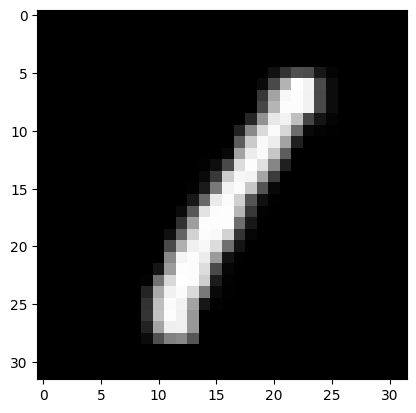

In [7]:
show_images(mnist_dataset[3][0])

In [8]:
train,val,_ = torch.utils.data.random_split(mnist_dataset,(0.5,0.1,0.4))


batch_size = 256
train_loader = torch.utils.data.DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)

val_loader = torch.utils.data.DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

In [9]:
print(f"Tamaño de dataset para entrenamiento: {len(train)}")
print(f"Tamaño de dataset para validación: {len(val)}")
# Usaremos solamente 30000 de las imágenes.


Tamaño de dataset para entrenamiento: 30000
Tamaño de dataset para validación: 6000


torch.Size([256, 1, 32, 32])


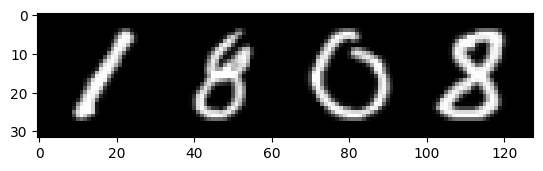

In [10]:
batch = next(iter(train_loader))[0]

print(batch.shape)
show_images(batch[::80])

## Añadiendo Ruido

In [15]:
scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.005
)

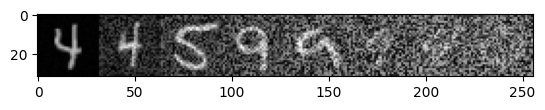

In [16]:
# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
batch = next(iter(train_loader))
x = batch[0][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images(noised_x)

In [17]:
noised_x.shape

torch.Size([8, 1, 32, 32])

## U-NET

In [18]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,  # 1 channels for grey scale
    sample_size=image_size,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),
    out_channels=1

).cuda()

# Pass a batch of data through to make sure it works. The dimensions of tensors must be the same
with torch.inference_mode():
    model.eval()
    out = model(noised_x.cuda(), timestep=timesteps.cuda()).sample
    model.train()

print(noised_x.shape)
print(out.shape)

torch.Size([8, 1, 32, 32])
torch.Size([8, 1, 32, 32])


# Entrenamiento

In [19]:
n_epochs = 8
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
loss_fn = torch.nn.functional.mse_loss
losses = []

In [20]:
# Bucle de entrenamiento
from torch import nn
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, scheduler: diffusers.schedulers, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses = 0
    losses_list = []

    # losses_list = []

    for nlote,x in enumerate(loader):
        x = x[0].cuda()

        ## Noise
        # Make noise
        noise = torch.randn_like(x).cuda()

        # Create random timesteps to the training
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (x.shape[0],)
        ).long().cuda()

        # Add Noise to images
        noisy_x = scheduler.add_noise(x,noise,timesteps)

        ## Forward Pass
        noise_pred = model(noisy_x, timesteps, return_dict = False)[0]
        
        
        ## Back-propagation
        # Calc of loss
        loss = loss_fn(noise_pred, noise)    #Calculo de loss
        
        # Save Loss
        losses_list.append(loss.item())

        # Steps of training
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas características para plotear al final
        train_losses += loss.item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print()

    train_losses /= nlotes
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {train_losses:>8f}")

    return losses_list

In [21]:
# Bucle de Validación
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, scheduler: diffusers.schedulers, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Cancelo el calculo del gradiente
        for x in loader:
            
            x = x[0].cuda()

            ## Noise
            noise = torch.randn_like(x)

            timesteps = torch.randint(
                0,
                scheduler.config.num_train_timesteps,
                (x.shape[0],)
            ).long().cuda()

            noisy_x = scheduler.add_noise(x, noise, timesteps)

            noise_pred = model(noisy_x, timesteps, return_dict=False)[0]       # Inferencia
            
            loss = loss_fn(noise_pred, noise)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"\t\t Validación: {val_losses:>8f}")

    return losses_list


In [ ]:
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    print(f"Iteración: {(epoch + 1)} / {n_epochs} -----------------------------")
    
    #Train
    train_loss  += train_loop(train_loader,model,scheduler,optimizer,loss_fn)
    
    #Validation
    val_output = val_loop(val_loader,model,scheduler,loss_fn)
    val_loss += val_output

print("Finalizado entrenamiento del modelo!")
#Tiempo de Entrenamiento: 23min

Iteración: 1 / 8 -----------------------------
Nº de lote:	 0
Loss:			 1.117551565170288

Nº de lote:	 10
Loss:			 0.13875210285186768

Nº de lote:	 20
Loss:			 0.1101015955209732

Nº de lote:	 30
Loss:			 0.08252837508916855

Nº de lote:	 40
Loss:			 0.071513831615448

Nº de lote:	 50
Loss:			 0.06904735416173935

Nº de lote:	 60
Loss:			 0.05534053593873978

Nº de lote:	 70
Loss:			 0.057601477950811386

Nº de lote:	 80
Loss:			 0.0479075163602829

Nº de lote:	 90
Loss:			 0.049702033400535583

Nº de lote:	 100
Loss:			 0.04176073148846626

Nº de lote:	 110
Loss:			 0.0383082777261734


	Accuracy/Loss Promedio
		Entrenamiento: 0.096103
		 Validación: 0.038517
Iteración: 2 / 8 -----------------------------
Nº de lote:	 0
Loss:			 0.03914741054177284

Nº de lote:	 10
Loss:			 0.0362803116440773

Nº de lote:	 20
Loss:			 0.0316573828458786

Nº de lote:	 30
Loss:			 0.03135611489415169

Nº de lote:	 40
Loss:			 0.03169051930308342

Nº de lote:	 50
Loss:			 0.03500865772366524

Nº de lote

In [23]:
torch.save(model.state_dict(),"First_train.pth")

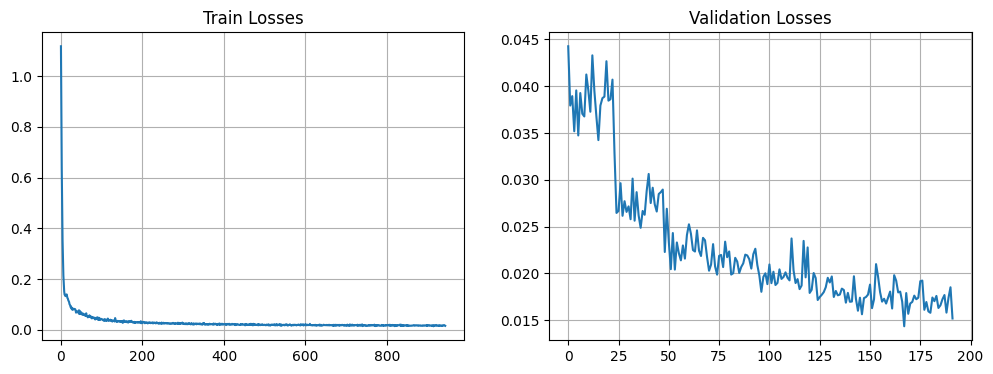

In [24]:
plt.subplots(1,2,figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Train Losses")
plt.plot(range(len(train_loss)),train_loss);
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation Losses")
plt.plot(range(len(val_loss)),val_loss);
plt.grid()

El valor de coste de validación final es mejor que en el caso base, aunque no sustancialmente.

Test de lectura de fichero de entrenamiento

In [ ]:
# model.load_state_dict(torch.load("Second_train.pth", weights_only=True))
# model.eval()

## Generación de Imágenes
2 Opciones:
* Usar pipeline ya montado
* Crear nuestro propio modelo de generación de imágenes

  0%|          | 0/1000 [00:00<?, ?it/s]

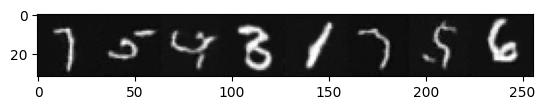

In [27]:
# Pipeline
pipeline = diffusers.DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=8).images

tensor_imgs = [transforms.functional.to_tensor(x) for x in ims]

show_images_list(tensor_imgs)

Se comprueba una mejora de los resultados, aunque no son comparables con la modificación de la base.
La modificación del tamaño del primer bloque ha provocado un aumento sustancial del tiempo de entrenamiento.

0


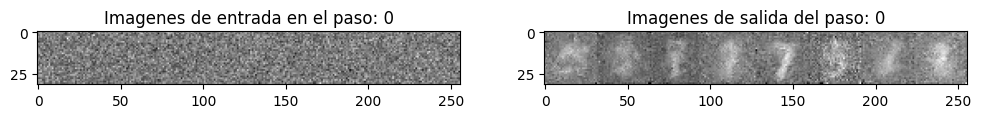

100


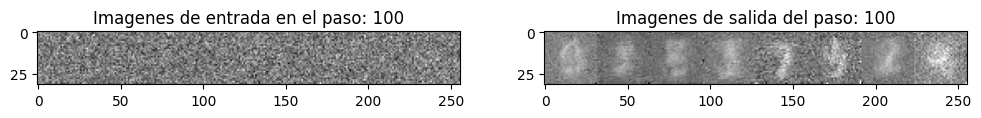

200


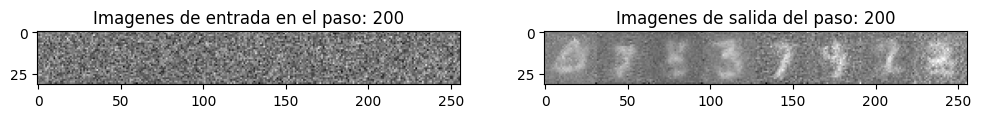

300


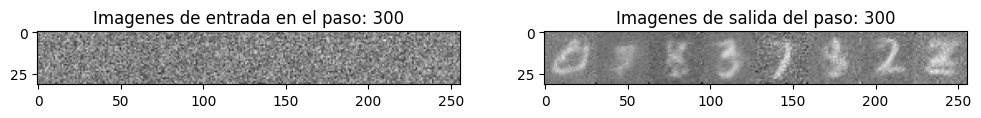

400


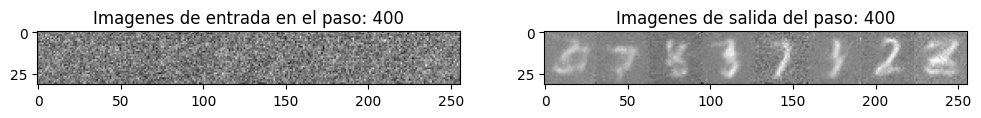

500


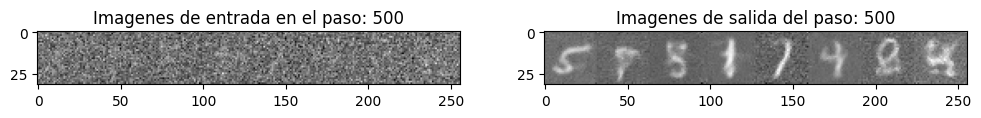

600


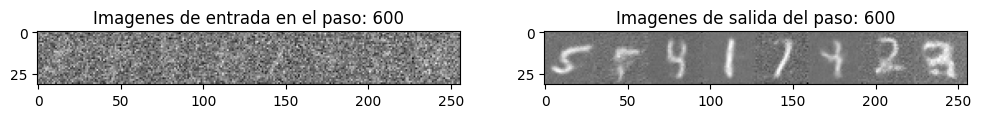

700


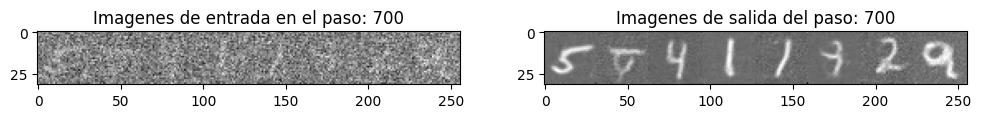

800


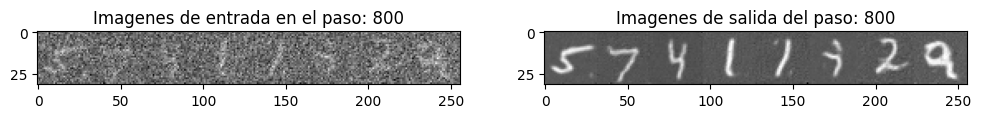

900


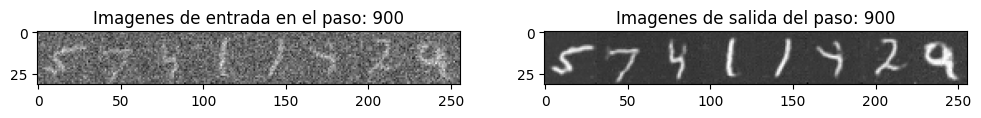

999


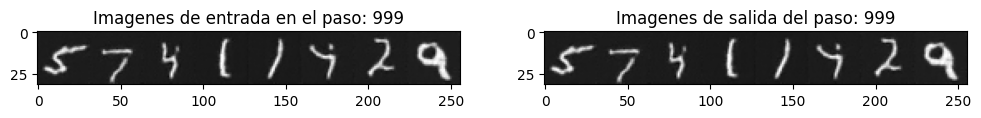

In [28]:
image = torch.randn_like(noised_x).cuda()
# Bucle de generación
for i, t in enumerate(scheduler.timesteps):

    with torch.inference_mode():                        # Iteramos una vez. No estamos entrenando, por lo que usamos el modo inferencia.
        noise_pred = model(image,t).sample

    # Calculamos la actualización de nuestras muestras aleatorias
    scheduler_output = scheduler.step(noise_pred, t, image)

    # volvemos a utilizar los datos como generados como entrada de la red
    image = scheduler_output.prev_sample

    # Mostramos los resultados.
    if (i%100 == 0) or (i == len(scheduler.timesteps)-1):
        # img_list = [torch.Tensor(normalizar_a_255_general(x.cpu().numpy())).int() for x in scheduler_output.prev_sample] + [torch.Tensor(normalizar_a_255_general(x.cpu().numpy())).int() for x in scheduler_output.pred_original_sample]
        img_list = [x for x in scheduler_output.prev_sample]
        generation_list = [x for x in scheduler_output.pred_original_sample]

        full_img = torch.cat(img_list,dim=2)
        full_generation = torch.cat(generation_list, dim=2)

        plt.subplots(1,2,figsize=(12,4))
        print(i)
        
        plt.subplot(1,2,1)
        plt.title("Imagenes de entrada en el paso: "+str(i))
        show_images(full_img.cpu());

        plt.subplot(1,2,2)
        plt.title("Imagenes de salida del paso: "+str(i))
        show_images(full_generation.cpu());

        plt.pause(0.1)